In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# load in abalone dataset
data = pd.read_csv('abalone.data', delimiter=',', 
              names = ['sex', 'length', 'diameter', 'height', 
                       'whole_weight', 'shucked_weight', 'viscera_weight', 
                       'shell_weight', 'rings'])

In [3]:
# encode sex as an ordinal
sex = data[['sex']]
sex_encoded = OrdinalEncoder().fit_transform(sex)
sex_encoded
data['sex_encoded'] = sex_encoded
data = data.drop(['sex'], axis=1)
data.rename(columns = {"sex_encoded":"sex"}, inplace=True)
data.head()

array([[2.],
       [2.],
       [0.],
       ...,
       [2.],
       [0.],
       [2.]])

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,2.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,2.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1.0


In [4]:
trainCount = 3133

def splitTrain(theData):
    return  theData.head(trainCount)

def splitTest(theData):
    return theData.tail(len(theData) - trainCount)

/Users/tonyd/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/tonyd/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/num

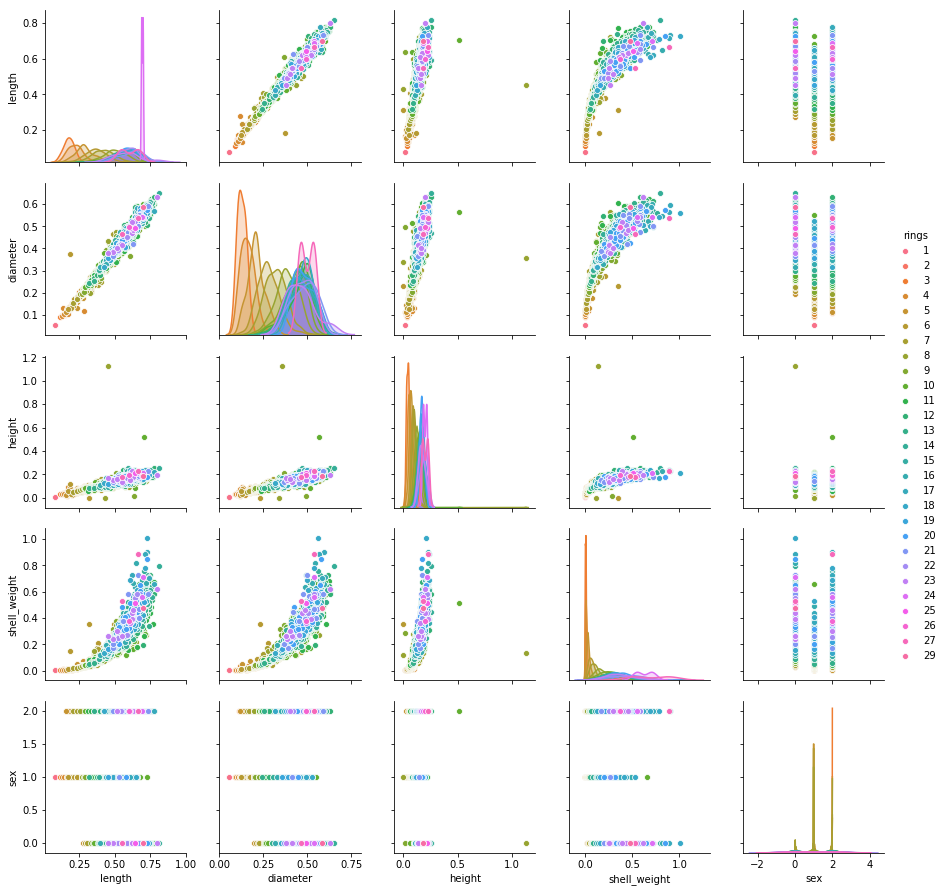

In [5]:

#plt.figure(figsize=(20,10))
 

# Make the plot
#parallel_coordinates(data, 'label', colormap=plt.get_cmap("Set3"))
#plt.show()

sns.pairplot(data,
         vars=["length", "diameter", "height", "shell_weight", "sex"], 
         hue="rings")


In [6]:
# Categorize abalone rings as age classes
# We will try various intervals to separate rings into age classes
def toClassOf5(value):
    if value < 5:
        return 0
    elif value < 10:
        return 1
    elif value < 15:
        return 2
    elif value < 20:
        return 3
    else:
        return 4
    
def toClassOf4(value):
    if value < 5:
        return 0
    elif value < 11:
        return 1
    elif value < 20:
        return 2
    else:
        return 3
    
def toClassOf3(value):
    if value < 9:
        return 0
    elif value < 12:
        return 1
    else:
        return 2

def toClassOf2(value):
    if value < 9:
        return 0
    else:
        return 1
    
ls = [
    ['2', splitTrain(data.rings.apply(toClassOf2)), splitTest(data.rings.apply(toClassOf2)), [],  [] ],
    ['3', splitTrain(data.rings.apply(toClassOf3)), splitTest(data.rings.apply(toClassOf3)), [],  [] ],
    ['4', splitTrain(data.rings.apply(toClassOf4)), splitTest(data.rings.apply(toClassOf4)), [],  [] ],
    ['5', splitTrain(data.rings.apply(toClassOf5)), splitTest(data.rings.apply(toClassOf5)), [],  [] ],
]
label_sets = pd.DataFrame(ls,columns=['name','labels_train', 'labels_test', 
                                      'best_params', 'prediction'])
label_sets.set_index('name', inplace=True)

In [7]:
# drop rings as this has now been transformed to labels (classes)
data = data.drop('rings', axis=1)

# standardize numeric features
data_norm = data.copy()
for col in data_norm:
    if col != 'sex':
        data_norm[col] = (data_norm[col] - data_norm[col].mean())/data_norm[col].std()

In [8]:
# We will perform knn classification on raw data as well as standardized data
# to compare metrics
ds = [
    ['data',      splitTrain(data),      splitTest(data),      label_sets ],
    ['data_norm', splitTrain(data_norm), splitTest(data_norm), label_sets.copy() ]
]
data_sets = pd.DataFrame(ds,columns=['name', 
                                     'features_train', 'features_test', 
                                     'label_sets'])
data_sets.set_index('name', inplace=True)

data_sets

,features_train,features_test,label_sets
name,,,
data,length diameter height whole_weight ...,length diameter height whole_weight ...,lab...
data_norm,length diameter height whole_weig...,length diameter height whole_weig...,lab...


In [9]:
from sklearn.model_selection import GridSearchCV

# Here are the parameters for knn classifier.  
# ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']

# We will focus on optimizing n_neighbors and weights
param_grid = [
    # try 12 (3×2) combinations of hyperparameters
    {'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']},
]

for row_index,theData in data_sets.iterrows():
    print('\n**************************')
    print(theData.name)
    print('***************************')
    
    for label_row_index,theLabels in theData.label_sets.iterrows():
        
        print('\n**********')
        print(theLabels.name)
        print('**********')

        # Create KNN Classifier
        knn = KNeighborsClassifier()

        # train across 5 folds, that's a total of (12)*3=36 rounds of training 
        grid_search = GridSearchCV(knn, param_grid, cv=3,
                                   scoring='accuracy', return_train_score=True)
        grid_search.fit(theData.features_train, theLabels.labels_train)
        theLabels['best_params'] = grid_search.best_params_

        grid_search.best_params_
        #grid_search.best_estimator_
        cvres = grid_search.cv_results_
        #for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        #    print(mean_score, params)
        


**************************
data
***************************

**********
2
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 14, 'weights': 'distance'}


**********
3
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 14, 'weights': 'distance'}


**********
4
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 14, 'weights': 'distance'}


**********
5
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 14, 'weights': 'distance'}


**************************
data_norm
***************************

**********
2
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 11, 'weights': 'distance'}


**********
3
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 14, 'weights': 'distance'}


**********
4
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 11, 'weights': 'distance'}


**********
5
**********


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [5, 11, 14], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

{'n_neighbors': 11, 'weights': 'distance'}

In [22]:
# Run knn classifier on data and standardized data
for row_index,theData in data_sets.iterrows():
    print('\n**************************')
    print(theData.name)
    print('***************************')
    
    for label_row_index,theLabels in theData.label_sets.iterrows():
        
        print('\n**********')
        print(theLabels.name)
        print('**********')

        n_neighbors = theLabels.best_params['n_neighbors']
        weights     = theLabels.best_params['weights']

        # Create KNN Classifier
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

        # Train the model using the training sets
        knn.fit(theData.features_train, theLabels.labels_train)


        # Predict the response for test dataset  
        if 'label' in theData.features_test.columns:
            test = theData.features_test.drop("label", axis=1)
        else:
            test = theData.features_test
        theLabels.prediction = knn.predict(test)
        print('accuracy:', metrics.accuracy_score(theLabels.labels_test, theLabels.prediction))




**************************
data
***************************

**********
2
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='distance')

accuracy: 0.8467432950191571

**********
3
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='distance')

accuracy: 0.6647509578544061

**********
4
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='distance')

accuracy: 0.7442528735632183

**********
5
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='distance')

accuracy: 0.7021072796934866

**************************
data_norm
***************************

**********
2
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')

accuracy: 0.8400383141762452

**********
3
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='distance')

accuracy: 0.6580459770114943

**********
4
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')

accuracy: 0.7289272030651341

**********
5
**********


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')

accuracy: 0.6733716475095786


/Users/tonyd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


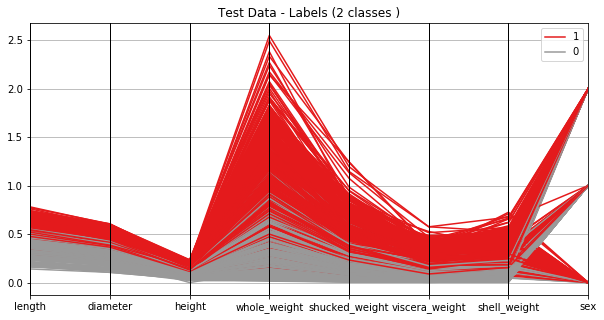

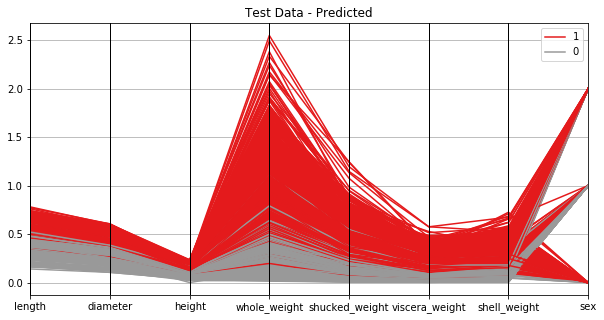

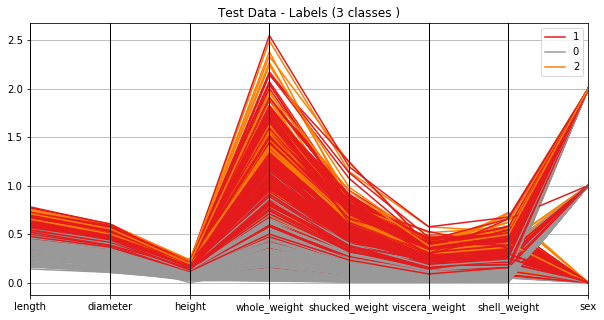

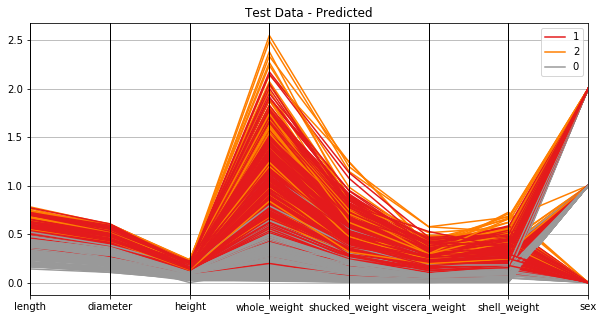

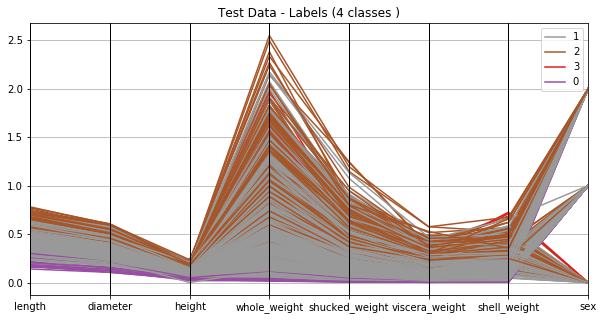

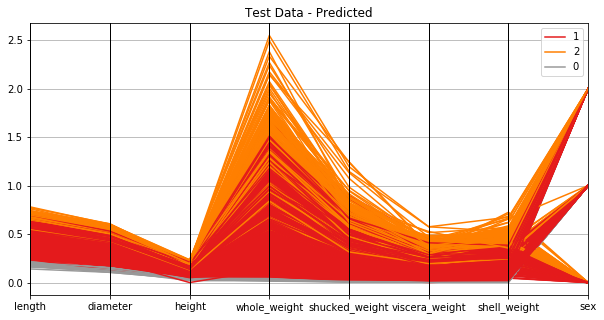

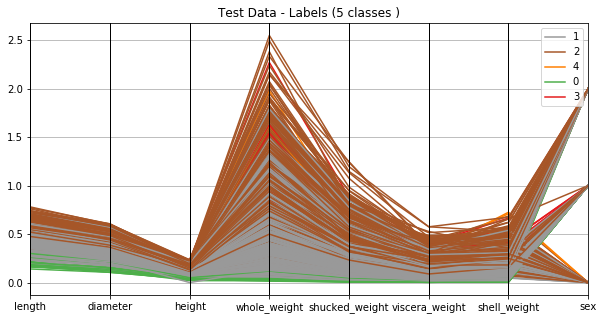

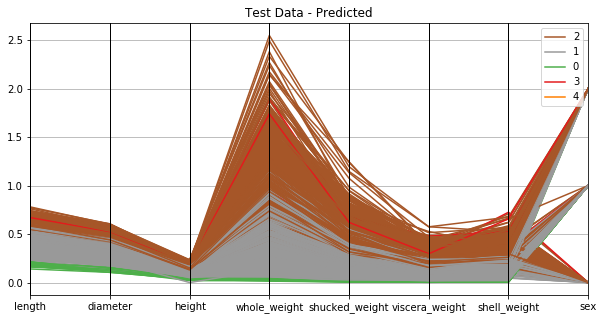

In [23]:
# Use parallel coordinates to visualize knn classification across all of the features
# The first figure shows the actual labels
# The second figure shows the predicted labels

import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

def plotParallelCoord(theData):


    for label_row_index,theLabels in theData.label_sets.iterrows():
        
        test = theData.features_test
        test['label'] = theLabels.labels_test
        
        plt.figure(figsize=(10,5))
        parallel_coordinates(test, 'label', 
                             colormap=plt.get_cmap("Set1"), sort_labels=True )
        plt.title("Test Data - Labels (" + theLabels.name + " classes )")
        plt.show()

        if 'label' in theData.features_test.columns:
            test = theData.features_test.drop("label", axis=1)
        else:
            test = theData.features_test
        test['predict'] = theLabels.prediction

        plt.figure(figsize=(10,5))
        parallel_coordinates(test, 'predict', 
                             colormap=plt.get_cmap("Set1"), sort_labels=True )
        plt.title("Test Data - Predicted")
        plt.show()
    


for row_index,theData in data_sets.iterrows():
    if (theData.name == 'data'):
        plotParallelCoord(theData)
